<a href="https://colab.research.google.com/github/isi-e/ml_nat/blob/main/ex_05_MLBasics2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Sheet No. 5

---

> Machine Learning for Natural Sciences, Summer 2025, TT.-Prof. Pascal Friederich, pascal.friederich@kit.edu
>
> Deadline: May 26th 2025, 08:00
>
> Tutor: henrik.schopmans@kit.edu
>
> **Please ask questions in the forum/discussion board and only contact the Tutor when there are issues with the grading**
---

**Topic**: This exercise sheet will focus on Bayesian statistics and Naive Bayes Classification

⚠️ **INFO.** In the tutorial session corresponding to this exercise, we will additionally ready and study the research paper `exercise_paper` which you can find in the corresponding Ilias folder. We will read parts of this paper during the tutorial, but you can optionally already have a look at it beforehand.

⚠️ **NOTE.** In an attempt to increase your opportunities for pre-submission self-checks of the assignments, hash-based assert statements will be provided to you throughout this notebook. These assert statements are used to give you an indication about the correctness of specific numeric values:

```python
some_variable = 0.73
assert hash(f'{some_variable:.2f}') == 4545130770134580, 'your value is likely incorrect!'
```

Also note that these hash-based checks do *NOT* check the value with the required precision of the hidden tests! Keep this in mind when contemplating to simply brute-force search the correct value. So even if a brute-forced value passes the self-check assert statement, it will likely *NOT* pass the hidden tests for the grading.

Therefore, if the hash-based self-check fails, your computed value is most likely incorrect. However, the self-check passing does not fully guarantee that correctness! The hash-based asserts statements are necessary but not sufficient conditions for the final result.

Please add here your group members' names and student IDs.

Names:

IDs:

In [1]:
##### DO NOT CHANGE #####
import io
import csv
import copy
import hashlib
import typing as t
from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad

hashcheck = lambda v: hashlib.sha256(v.encode()).hexdigest()

##### DO NOT CHANGE #####

# 5 Bayes' theorem

This section will review Bayes' rule and some additional important formulas from lecture 3. Bayes' rule defines how the posterior probability

$$
\boxed{p(y|x) = \frac{p(x|y) p(y)}{p(x)} }
$$

is defined by the likelihood $p(x|y)$, the evidence $p(x)$ and the prior $p(y)$. Here, $p(x|y)$ is a conditional probability, which gives the probability of event $x$ occurring given the condition $y$.

**Practical Example.** Lets clarify this with a concrete example: Here we'll assume that $y \in \{ \mathrm{healthy}, \mathrm{sick} \}$ is a random discrete variable that tells us if a person has actually caught a certain disease. Additionally, $x \in \{ \mathrm{negative}, \mathrm{positive} \}$ is the outcome of a test that is supposed to detect that disease. By looking at population statistics we can see that only about 1 in 1000 people will actually ever catch this disease in their life. Therefore, we know that $p(y=\mathrm{sick}) = 1 / 1000 = 0.001$ and likewise $p(y=\mathrm{healthy}) = 1 - p(y=\mathrm{sick}) = 0.999$. Additionally, through clinical tests we may also know the overall probability of a test being positive or negative $p(x)$ and the *sensitivity* of the test $p(x=\mathrm{positive}|y=\mathrm{sick})$, which is the probability of the test showing a positive result when a person actually has the disease. All of this information can then be used to determine the conditional probability $p(y=\mathrm{sick}|x=\mathrm{positive})$, for example, of having the disease when the test result is positive. Interestingly, $p(y=\mathrm{healthy}|x=\mathrm{positive})$ often times turns out to be higher than intuitively expected - especially for rare diseases. This is because for really rare diseases the term $p(y=\mathrm{healthy})$ is so high that a possible test would need an incredibly high sensitivity to compensate for this.

**Marginalization.** Marginalization is the process of "eliminating a variable" from a distribution. For continuous variable $y$, the marginalized distribution

$$
p(x) = \int\limits_{-\infty}^{+\infty} p(x,y=s) ds = \int\limits_{-\infty}^{+\infty} p(x|y=s) p(y=s) ds
$$

is defined as the integral over all possible values of $y$. Similarly for a discrete variable $y$, the marginalization

$$
p(x) = \sum\limits_k p(x,y=k) = \sum\limits_k p(x|y=k) \; p(y=k)
$$

is defined as the discrete sum over all possible realizations $k$ of the variable.

## 5.1 Exam Qualifications

**The purpose of exams.** Students generally go to university to learn. Each lecture is designed to teach students about some specific aspect of a subject area (physics, chemistry, computer science etc.). In this process, each course has a specific set of learning goals about certain topics that students should be familiar with after completing the course. So there exists an abstract set of qualifications that a student should obtain by taking each course. At the end of each course there is an exam which is supposed to test whether a student sufficiently obtained these qualifications. However, the definition of these qualifications may be complex and it is easy to imagine that there can be a rift between these true qualifications and what an exam is able to test in a limited amount of time. For example, it is likely easy to recall some fellow student which managed to pass a certain exam even with a *shaky* understanding of the topic. There might also be the opposite case of students failing the exam even though they seemed to have a good grasp of the topic. Ultimately, one can say that the outcome of an exam is not always perfectly aligned with the knowledge that a person has actually acquired.

**A case study.** While Prof. Friederich is grading the ML4Nat exam one day, he wonders how effective his own exam is at judging whether or not a student has actually acquired all the necessary qualifications from his lecture. After thinking about it for a while, he decides that this can be framed as a question of probabilities: *What is the probability that a student has acquired all the necessary qualification, given that they passed the exam?*

Formally, we can define two random variables $x$ and $y$. The discrete random variable $y = \{ \mathrm{qualified}, \mathrm{unqualified} \}$ captures whether a student has actually acquired the necessary qualification or not. The second discrete random variable $x = \{ \mathrm{pass}, \mathrm{fail} \}$ captures whether a student has passed the exam or failed it. To answer the initial question we therefore have to calculate the probability

$$
P(y=\mathrm{qualified}|x=\mathrm{pass})
$$

that a student is sufficiently qualified *under the condition* that they have passed the exam. This can be done by applying Bayes rule:

$$
P(y=\mathrm{qualified}|x=\mathrm{pass}) = \frac{ P(x=\mathrm{pass}|y=\mathrm{qualified}) \cdot P(y=\mathrm{qualified})}{P(x=\mathrm{pass})}
$$

This requires us to provide an estimate of the following 3 probabilities:

- $P(x=\mathrm{pass})$: The overall probability of passing the exam.
- $P(y=\mathrm{qualified})$: The prior probabilitiy of having acquired the necessary qualifications.
- $P(x=\mathrm{pass} | y=\mathrm{qualified})$: The probability of passing the exam under the condition of possessing the necessary qualifications.

To estimate the probability $P(x=\mathrm{pass} | y=\mathrm{qualified})$ of passing the exam when possessing the necessary qualifications, Prof. Friederich makes the assumption that all of his PhD students already possess all the necessary qualifications. All PhD students take the exam, and 9 out of 10 pass it.

To estimate the probability $P(y=\mathrm{qualified})$, Prof. Friederich draws from his experience of talking to various students throughout the semester and estimates that about $80\%$ of the students generally acquire the necessary qualifications.

**🛠️ Task 5.1 (1 points)** Fill in the numeric values for the probabilities using the information provided in the previous description. Set the value of the variable ``p_y`` to the prior probability of possessing the necessary qualifications and the value of the variable ``p_x_y`` as the conditional probability of passing the exam under the condition of possessing the necessary qualification.

In [2]:
# TASK: Provide estimates for the task probabilities from the previous description.

# HINT: Give the probabilities as float ratios between 0 and 1 and NOT as percentages

p_y: float = 0.8
p_x_y: float = 0.9

# YOUR CODE HERE


In [3]:
##### DO NOT CHANGE #####
# ID: test-5-1-probabilities-text - possible points: 2

assert isinstance(p_y, float)
assert 0 <= p_y <= 1.0, 'give probabilities as ratios in the range [0, 1] and not as percentages!'
assert hashcheck(f'{p_y:.1f}') == '1e9d7c27c8bbc8ddf0055c93e064a62fa995d177fee28cc8fa949bc8a4db06f4', 'p_y is likely incorrect!'

assert isinstance(p_x_y, float)
assert 0 <= p_x_y <= 1.0, 'give probabilities as ratios in the range [0, 1] and not as percentages!'
assert hashcheck(f'{p_x_y:.1f}') == '8139b33952401b3ee0e2ca84651cb9a1d7f66d442bf908f9cf1f53ea746e5801', 'p_x_y is likely incorrect!'


##### DO NOT CHANGE #####

**🛠️ Task 5.2 (2 points)** Estimate the overall chance of passing the exam $P(x=\mathrm{pass})$. This probability can be very accurately approximated by looking at the results of the previous years. Use the given statistics of the previous years to calculate an approximate value of $P(x=\mathrm{pass})$ and assign the value to the variable ``p_x``

In [5]:
# A list that contains the exam statistics of the previous years. Each element is a dictionary that contains
# the following string keys:
# - year: The year in which the exam was written
# - pass: the number of students that passed the exam
# - fail: the number of students that failed the exam
previous_statistics: list[dict[str, int]] = [
    {
        'year': 2021,
        'pass': 162,
        'fail': 35,
    },
    {
        'year': 2022,
        'pass': 174,
        'fail': 23,
    },
    {
        'year': 2023,
        'pass': 166,
        'fail': 31,
    }
]


# TASK: Provide estimates for the task probabilities by calculating from the given information.

# HINT 1: Give the probabilities as float ratios between 0 and 1 and NOT as percentages

# HINT 2: One can think of *multiple* ways to estimate the overall probability of passing
#         from the given past statistics. If the self-check fails, try to think of an
#         alternate approach.

overall_ratio = 0
for year in previous_statistics:
  total_students = year['pass'] + year['fail']
  year['pass_ratio'] = year['pass'] / total_students
  overall_ratio += year['pass_ratio']
p_x: float = (1/3)*overall_ratio


# YOUR CODE HERE


In [6]:
##### DO NOT CHANGE #####
# ID: test-5-2-exam-statistics - possible points: 2

assert isinstance(p_x, float)
assert p_x < 1.0, 'give probabilities as ratios in the range [0, 1] and not as percentages!'
assert hashcheck(f'{p_x:.2f}') == '1e181f0934d441445f03ff51c972ef44275b830c10a80401e53b27bf5baf327a', "p_x answer is likely incorrect!"


##### DO NOT CHANGE #####

**🛠️ Task 5.3 (1 point)** Given the probabilities from the previous task, now apply Bayes' Rule and calculate the probability $P(y=\mathrm{qualified}\;|\;x=\mathrm{pass})$ that a student has acquired the necessary qualifications, given that they have passed the exam. Assign the resulting conditional probability to the variable ``p_y_x``.

In [11]:
# TASK: Compute the conditional probability p(y=qualified|x=pass) using previously known / estimated
#       probabilities using bayes rule and assign it to the variable p_y_x

p_y_x: float = p_x_y * p_y / p_x

# YOUR CODE HERE


In [9]:
##### DO NOT CHANGE #####
# ID: test-5-3-conditional-probability - possible points: 1

print(f'If a student has successfully passed the exam, there is a {p_y_x*100:.2f}% percent '
      f'chance that they have actually acquired the necessary qualifications from the course!')
assert isinstance(p_y_x, float)
assert 0 <= p_y_x <= 1.0, 'give probabilities as ratios in the range [0, 1] and not as percentages!'
assert hashcheck(f'{p_y_x:.2f}') == '1e181f0934d441445f03ff51c972ef44275b830c10a80401e53b27bf5baf327a'


##### DO NOT CHANGE #####

If a student has successfully passed the exam, there is a 84.76% percent chance that they have actually acquired the necessary qualifications from the course!


So in the end we have found out that there is a relatively high - yet not completely certain - chance of having acquired the necessary qualifications when passing the exam. Ultimately, every form of examination is trying to maximize this metric. As everyone might have already experienced, different exams achieve this ideal to different degrees.

**The data-centric approach.** In the previous section, we have solved the initial question concerning exam
qualifications in a *classic* fashion through a combination of educated guesses and statistics. In the end, such an approach has to be customized for each individual application. In other applications, it might be more difficult to estimate certain probabilities and past statistics might not be accessible. Overall, this kind of approach requires a lot of domain knowledge, which might or might not be available in certain situations. Contrary to this knowledge-centric approach is the *data-centric* approach - on which machine learning methods are generally based. Instead of manually deriving a solution, it is automatically extracted from large amounts of raw data.

## 5.2 Data Analysis

**data collection.** We return to our example of exam qualifications - trying to answer the question of how well Prof. Friederich's exam is at determining whether students have obtained the necessary qualifications. However, in the following sections we approach this question from a *data-centric* prespective. To do this, we first need the necessary raw data.

**student survey.** We assume that Prof. Friederich conducts a large-scale (hypothetical) survey among his students. Following the most recent exam, he randomly selects a subset of the students and invites them to a personal interview. Based on each 3 hour personal interview about the content of the lecture, Prof. Friederich is certain about the true qualifications of each student. Slowly, over the course of multiple weeks, this survey results in a dataset consisting of each students true qualification state $y_{\mathrm{true}} \in \{ \mathrm{qualified}, \mathrm{unqualified} \}$ in addition to their exam results $x \in \{ \mathrm{pass}, \mathrm{fail} \}$. Additionally, each student is asked to provide the following additional information:

- The number of hours $t \in [0, \infty)$ that they have invested into studying.
- The number of points $r \in [0, 100]$ that a student has achieved in the exercises alongside the lecture.
- The boolean state $l \in \{ \mathrm{seldom}, \mathrm{regular} \} = \{0,1\}$ of how frequently a student has attended the lecture.
- The boolean state $g \in \{ \mathrm{ignored}, \mathrm{used} \} = \{0, 1\}$ of whether a student has used old exams during studying.

**🛠️ Task 5.4 (1 point)** The dataset is available at https://bwsyncandshare.kit.edu/s/YwPT62wGYtK7HCL in CSV format. Your task is to write the code to retrieve this dataset from the remote file storage server and load it as a ``pandas.DataFrame`` object into the local variable ``df`` for further processing.

In [12]:
import io
import requests
import pandas as pd


def nextcloud_download(url: str) -> str:
    """
    Downloads the *content* of a file from a nextcloud server.

    :param url: the absolute URL of the file on the nextcloud server

    :returns: the string content of the file
    """
    response = requests.get(f'{url}/download')
    content = response.content.decode('utf-8')
    return content


# TASK: Use the ``nextcloud_download`` function to download the dataset and then load
#       the dataset into the given ``df`` variable as a pandas dataframe object.

df: pd.DataFrame = pd.read_csv(io.StringIO(nextcloud_download('https://bwsyncandshare.kit.edu/s/YwPT62wGYtK7HCL')))

# YOUR CODE HERE


In [13]:
##### DO NOT CHANGE #####
# ID: test-5-4-load-dataset - possible points: 1

assert isinstance(df, pd.DataFrame)
assert len(df) != 0
assert len(df) == 264

# NOTE: The hidden tests will test some randomly chosen example elements from the dataset.


##### DO NOT CHANGE #####

**🛠️ Task 5.5 (1 point)** In the previous section we wanted to approximate the conditional probability of $P(y=\mathrm{qualified}\;|\;x=\mathrm{pass})$ of a student possessing the required qualification under the condition of having passed the exam. Empirically estimate this conditional probability directly from the student survey data and assign the value to the variable ``p_y_x_data``.

In [20]:
# TASK: Compute the conditional probability p(y=qualified | x=pass) directly from the dataset and
#       store the resulting float value in this variable.

passed_students = df[df['passed'] == 1]

qualified_and_passed = passed_students[passed_students['qualified'] == 1].shape[0]
p_y_x_data: float = qualified_and_passed / passed_students.shape[0]
# YOUR CODE HERE


0.8133333333333334


In [18]:
##### DO NOT CHANGE #####
# ID: test-5-5-direct-probability - possible points: 1

assert isinstance(p_y_x_data, float), 'please give solution as a float'
assert 0.0 <= p_y_x_data <= 1.0, 'please give probability in the range [0, 1]'
assert hashcheck(f'{p_y_x_data:.1f}') == '1e9d7c27c8bbc8ddf0055c93e064a62fa995d177fee28cc8fa949bc8a4db06f4'


##### DO NOT CHANGE #####

In [19]:
##### DO NOT CHANGE #####
print(f'Based on the student survey dataset, if a student has successfully passed the exam, there is a {p_y_x_data*100:.2f}% percent '
      f'chance that they have actually acquired the necessary qualifications from the course!')

##### DO NOT CHANGE #####

Based on the student survey dataset, if a student has successfully passed the exam, there is a 81.33% percent chance that they have actually acquired the necessary qualifications from the course!


**🛠️ Task 5.6 (2 points).** Before continuing with the remaining execises, it makes sense to do some data exploration to get a proper overview of the data.

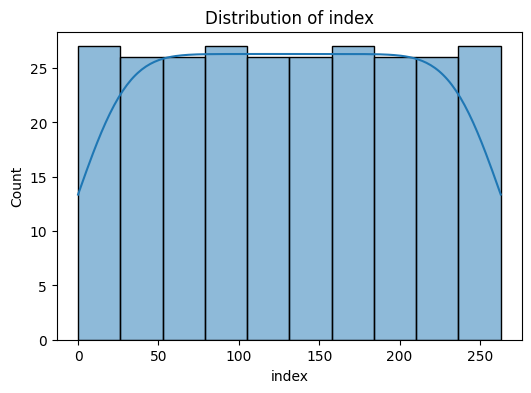

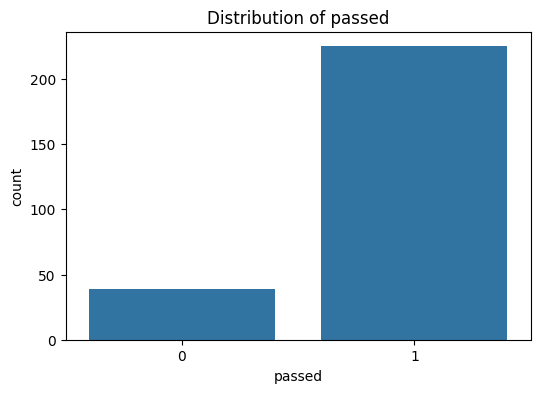

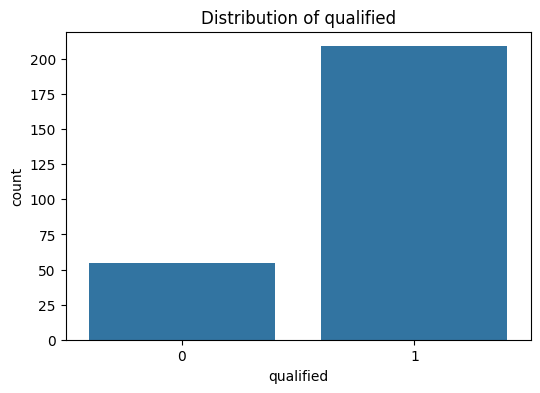

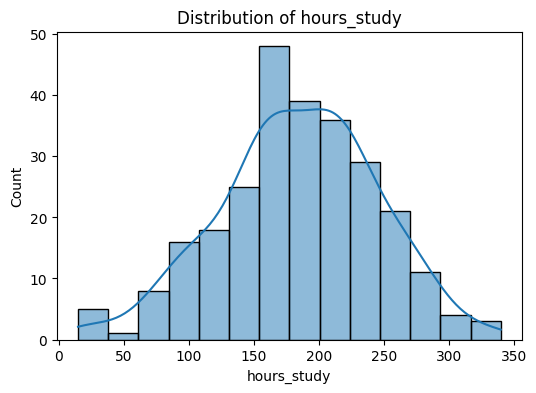

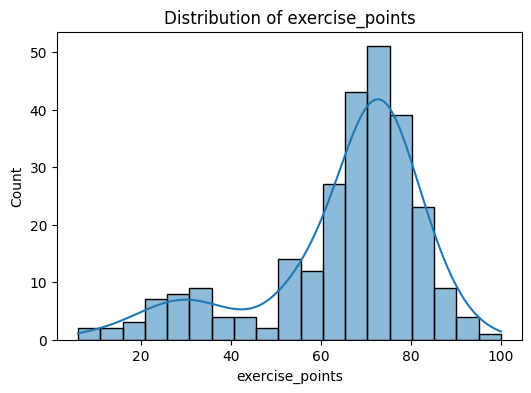

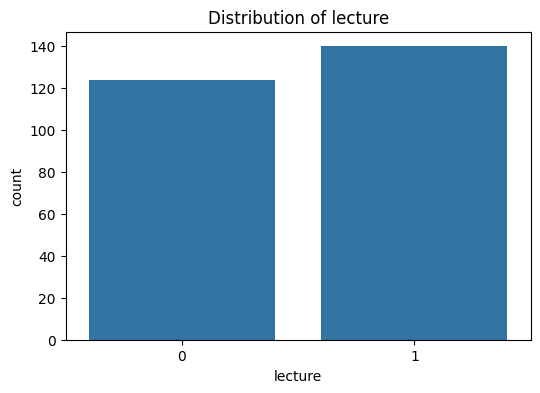

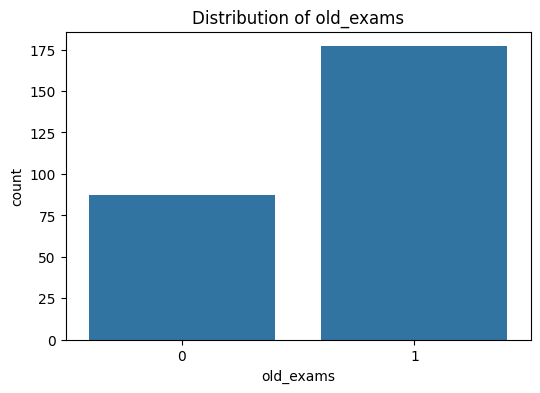

In [21]:
# TASK: Plot the data distribution for every column in the student survey dataset to gain some basic
#       understanding of the data.
#       Additionally, fill in the mean values of each of the dataset columns to the ``mean_values``
#       dictionary.

# HINT: Try to think of a way to do the visualization automatically. Try to generically iterate over the
#       columns of the dataset. What are appropriate visualizations for continuous vs. discrete variables?
#       What is a simple method to automatically decide whether an unknown column likely contains
#       cont. vs. discrete data?

mean_values: dict[str, float] = {
    'hours_study': 0.0,
    'exercise_points': 0.0,
    'qualified': 0.0,
    'passed': 0.0,
    'lecture': 0.0,
}

# YOUR CODE HERE
for column in df.columns:
    # Calculate and store the mean value
    mean_values[column] = df[column].mean()

    # Determine if the column is likely discrete or continuous
    # A simple heuristic is to check the number of unique values.
    # If the number of unique values is small compared to the total number of rows,
    # it's likely discrete. This is a heuristic and might need adjustment
    # based on the specific dataset.
    if df[column].nunique() < df.shape[0] * 0.1 and df[column].dtype in ['int64', 'object', 'bool']:
        # Treat as discrete/categorical
        plt.figure(figsize=(6, 4))
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
        plt.show()
    else:
        # Treat as continuous
        plt.figure(figsize=(6, 4))
        sns.histplot(data=df, x=column, kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()


In [22]:
##### DO NOT CHANGE #####
# ID: test-5-6-exploration - possible points: 2

assert isinstance(mean_values, dict)
assert len(mean_values) >= 5

# NOTE: The hidden tests will compare the values in the mean_values dict with the
#       true values


##### DO NOT CHANGE #####

**practice makes perfect.** Since students provided addditional information during the survey, we can now use this information to approximate numerous other conditional probabilities as well. Intuitively, the amount of time spent studying makes sense as an significant indication of learning progress. Therefore in the following section we would like to investigate the conditional probability $P(y=\mathrm{qualified}|t)$ of being qualified under the condition of having spent $t$ hours studying.



In [ ]:
##### DO NOT CHANGE #####
qualified = df['qualified']
hours_study = df['hours_study']

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(10, 5)
)

sns.histplot(hours_study, ax=ax1, binwidth=10)
ax1.set_xlabel('$t$')
ax1.set_title('Hours of study $t$')

s = df['qualified'].value_counts(sort=False)
sns.barplot(ax=ax2, x=s.index, y=s.values, order=s.index)
ax2.bar_label(ax2.containers[0]);
ax2.set_xlabel('$x$')
ax2.set_title('Qualification $y$')

##### DO NOT CHANGE #####

**🛠️ Task 5.7 (2 points)** In this exercise we want to determine $P(y=\mathrm{qualified}|t)$ for all possible values of $t \in \{0, \dots, 400\}$. Calculate the conditional probabilities from the student survey dataset and use them to fill the ``p_y_t`` array.

In [ ]:

# This is an array that contains all possible integer values for the hours of study
# (all possible *t* values) in ascending order.
# [0 1 2 3 4 ... 400]
ts: np.ndarray = np.arange(0, 400)

# TASK: Fill the array p_y_t with the empirically estimated conditional probabilities
#       p(x=qualified|t) that a student has achieved the necessary qualifications
#       under the condition of having studied *exactly* t hours.

# HINT: If there are no students having exactly studied a given number of hours
#       Leave the value at this position in the array at zero.

# You may optionally also fill the array num_t with the number of students that studied *exactly* t hours.


p_y_t: np.ndarray = np.zeros_like(ts, dtype=float)

num_t: np.ndarray = np.zeros_like(ts, dtype=float)

# YOUR CODE HERE
raise NotImplementedError()

# ~ plotting the solution

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(10, 5)
)

# p(x=qualified) over different t values
ax1.scatter(ts, p_y_t)
ax1.set_ylabel('p')
ax1.set_xlabel('t')
ax1.set_title('$P(x=\mathrm{qualified}\;|\;t)$')

# number of students having studied exactly t hours
ax2.scatter(ts, num_t)
ax2.set_ylabel('num')
ax2.set_xlabel('t')
ax2.set_title('Number of students for $t$ hours of study')

In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-7-hours-study - possible points: 3

assert isinstance(p_y_t, np.ndarray), 'solution must be array'
assert len(p_y_t) == 400, 'solution is missing elements'
assert np.max(p_y_t) > 0.1, 'solution is likely still empty'
assert np.isclose(p_y_t[0], 0.0), 'solution is likely incorrect'

# NOTE: The hidden tests will check some selected values from the array to match
#       the correct values

# HINT: Only the "p_y_t" array is relevant to the solution.


##### DO NOT CHANGE #####

Unfortunately, the resulting plot doesn't seem to be very informative. The main problem is that there is simply not enough data available to properly justify an empirical approximation of these probabilities. For most exact values of $t$ there exists not even a single sample in the given student survey dataset to estimate from and there seem to be no more than 20 students for any value of $t$.

So to improve these results we'd need a *much* larger dataset size, such that there exists a reasonable number of students for each possible number of hours $t$. *Alternatively*, we can slightly modify the problem. Instead of asking for the probability for each exact value of $t$ we can consider a certain range of values. So, for example, one could calculate the probability $P(x=\mathrm{qualified}\;|\;\tau \leq t \leq \tau + 50)$ of having the necessary qualification when having studied between $\tau$ and $\tau + 50$ hours. In this formulation, a factor $\times 50$ more samples are used for the empirical estimation of each probability.

**🛠️ Task 5.8 (2 points)** In this exercise we want to determine $P(y=\mathrm{qualified}|\tau \leq t \leq \tau + 50)$ for all possible values of $\tau \in \{0, \dots, 400\}$. Here we use a possible range of values instead of exact values for $t$ to get better probability estimates. Calculate the conditional probabilities from the student survey dataset and use them to fill the ``p_y_tau`` array.

In [ ]:
# This is an array that contains all possible integer values for the hours of study
# (all possible *t* values) in ascending order.
# [0 1 2 3 4 ... 400]
ts: np.ndarray = np.arange(0, 400)

# TASK: Fill the array p_y_tau with the empirically estimated conditional probabilities
#       p(x=qualified|tau <= t <= tau + 50) that a student has achieved the necessary qualifications
#       under the condition of having studied between tau and tau+50 hours.

p_y_tau: np.ndarray = np.zeros_like(ts, dtype=float)

# YOUR CODE HERE
raise NotImplementedError()

fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(10, 5)
)

# p(x=qualified) over different tau values
ts_ = [t for i, t in enumerate(ts) if p_y_tau[i] > 0]
ps_ = [p for i, p in enumerate(p_y_tau) if p_y_tau[i] > 0]
ax.scatter(ts_, ps_, alpha=0.3)
ax.plot(ts_, ps_)
ax.set_ylabel('p')
ax.set_xlabel(r'$\tau$')
ax.set_title(r'$P(x=\mathrm{qualified}\;|\; \tau < t < \tau + 50)$')

In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-8-smoothing - possible points: 2

assert isinstance(p_y_tau, np.ndarray), 'solution must be array'
assert len(p_y_tau) == 400, 'solution is missing elements'
assert np.max(p_y_tau) > 0.1, 'solution is likely still empty'
assert np.isclose(p_y_tau[0], 0.2), 'solution is likely incorrect'

# NOTE: The hidden tests will test a selection of 5 random elements of the p_y_tau array
#       against their true values.



##### DO NOT CHANGE #####

The resulting plot is much more informative! Due to the increased sample size, there are no more missing values and we can clearly see a trend. For $\tau = 0$ (study between 0 and 50 hours), the probability starts off relatively low and then rises more or less steadily for an increasing amount of studying until it saturates to almost $\approx 100\%$ for $\tau > 300$.

**flipping the condition.** In the previous section we have computed the conditional probability $P(x=\mathrm{qualified} \;|\; t)$ of a student having obtained the necessary qualifications after studying for $t$ hours. In the following section we want to look at the reverse case $P(t \;|\; x=\mathrm{qualified})$ which models the likelihood of having worked $t$ hours under the condition of belonging to the group of students that have obtained the necessary qualifcations. This might seem counterintuitive at first, but we'll see that this statistic will be useful to make future predictions.

**🛠️ Task 5.9 (2 points)** In this task you'll have to compute the flipped conditional probabilities $P(t \;|\; x=\mathrm{unqualified})$ and $P(t \;|\; x=\mathrm{qualified})$ from the student survey dataset. Save the results for all values $t \in \{0, \dots, 400\}$ into the two variables ``p_t_y0`` and ``p_t_y1`` respectively.

In [ ]:
# This is an array that contains all possible integer values for the hours of study
# (all possible *t* values) in ascending order.
# [0 1 2 3 4 ... 400]
ts: np.ndarray = np.arange(0, 400)

p_t_y0: np.ndarray = np.zeros_like(ts, dtype=float)
p_t_y1: np.ndarray = np.zeros_like(ts, dtype=float)

# YOUR CODE HERE
raise NotImplementedError()


fig_t_y, (ax_y0, ax_y1) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(10, 5)
)

# p(t | y=unqualified)
ax_y0.plot(ts, p_t_y0, color='tab:blue')
ax_y0.set_ylabel(r'$p$')
ax_y0.set_xlabel(r'$t$')
ax_y0.set_title(r'$P(t\;|\;y=\mathrm{unqualified})$')

# p(t | y=qualified)
ax_y1.plot(ts, p_t_y1, color='tab:orange')
ax_y1.set_ylabel(r'$p$')
ax_y1.set_xlabel(r'$t$')
ax_y1.set_title(r'$P(t\;|\;y=\mathrm{qualified})$')

In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-9-conditional-qualified - possible points: 1

assert isinstance(p_t_y1, np.ndarray), 'solution must be array'
assert len(p_t_y1) == 400, 'solution is missing elements'
assert np.isclose(np.sum(p_t_y1), 1.0), 'solution is not a proper density distribution!'

# NOTE: The hidden tests will check the statistical properties of the value arrays (mean, variance).


##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-9-conditional-unqualified - possible points: 1

assert isinstance(p_t_y0, np.ndarray), 'solution must be array'
assert len(p_t_y0) == 400, 'solution is missing elements'
assert np.isclose(np.sum(p_t_y0), 1.0), 'solution is not a proper density distribution!'


##### DO NOT CHANGE #####

The first thing we notice here is that we encounter somewhat the same problem as in the previous section. For some values of $t$ the probability is zero since there weren't any students who reported that exact study time. However, it is still possible to recognize the overall shape of the distributions - especially in case of the second plot $P(t\;|\;y=\mathrm{qualified})$, since it is based on more overall samples. In this case, we can vaguely recognize the shape as a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution).

**Curve fitting.** Based on this insight, an option to obtain a smoother probability distribution is to simply fit the existing data to a continuous Gaussian. Based on the formula for the Gaussian distribution

$$
p(t;\mu,\sigma) \sim \frac{1}{\sqrt{2 \pi \sigma^2}} \mathrm{exp}(\frac{- (t - \mu)^2}{2 \sigma^2})
$$

this only requires to determine the *mean* $\mu$ and the *standard deviation* $\sigma$ from the given data.

**🛠️ Task 5.10 (2 points)** For this task, you'll have to implement the two functions ``gauss_y0`` and ``gauss_y1`` which should implement Gaussian distributions fitting the conditional probabilities $P(t \;|\; y=\mathrm{unqualified})$ and $P(t \;|\; y=\mathrm{qualified})$, respectively. To do this, determine $\sigma$ and $\mu$ in each case and use the given formula to return the probability density.

In [ ]:
# TASK: Since the direct estimations of the conditional probabilities p(t|y=0) and p(t|y=1) have
#       a lot of missing values we want to fit gaussian distributions instead. The two functions
#       below should be implemented to return the probability density value for these Gaussian
#       distributions for any continuous value of t.

def gauss_y0(t: float) -> float:

    # YOUR CODE HERE
    raise NotImplementedError()

    return 0.0

def gauss_y1(t: float) -> float:

    # YOUR CODE HERE
    raise NotImplementedError()

    return 0.0


fig = copy.deepcopy(fig_t_y)
ax_y0, ax_y1 = fig.get_axes()

df_y0 = df[df['qualified'] == 0]
df_y1 = df[df['qualified'] == 1]

# p(t | y=unqualified)
values_y0 = [gauss_y0(t) for t in ts]
ax_y0.plot(ts, values_y0, color='blue')
ax_y0.fill_between(ts, values_y0, color='blue')

avg_y0, _ = quad(lambda t: t * gauss_y0(t), -np.inf, np.inf)
var_y0, _ = quad(lambda t: (t - avg_y0)**2 * gauss_y0(t), -np.inf, np.inf)
std_y0 = np.sqrt(var_y0)

ax_y0.axvline(avg_y0, label=r'$\mu$' + f' = {avg_y0:.2f} hrs', color='black', ls='-', zorder=10)
ax_y0.hlines(np.mean(ax_y0.get_ylim()), avg_y0 - std_y0, avg_y0 + std_y0,
             label=r'$\sigma$' + f' = {std_y0:.2f} hrs', color='black', ls='--')
ax_y0.axvline(np.mean(df_y0['hours_study']))
ax_y0.legend(loc='upper right')
ax_y0.set_title(r'$P(t\;|\;y=\mathrm{unqualified})$')

# p(t | y=qualified)
values_y1 = [gauss_y1(t) for t in ts]
ax_y1.plot(ts, values_y1, color='red')
ax_y1.fill_between(ts, values_y1, color='red')

avg_y1, _ = quad(lambda t: t * gauss_y1(t), -np.inf, np.inf)
var_y1, _ = quad(lambda t: (t - avg_y1)**2 * gauss_y1(t), -np.inf, np.inf)
std_y1 = np.sqrt(var_y1)

ax_y1.axvline(avg_y1, label=r'$\mu$' + f' = {avg_y1:.2f} hrs', color='black', ls='-')
ax_y1.hlines(np.mean(ax_y1.get_ylim()), avg_y1 - std_y1, avg_y1 + std_y1,
             label=r'$\sigma$' + f' = {std_y1:.2f} hrs', color='black', ls='--')
ax_y1.legend(loc='upper right')

fig

In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-10-curve-fitting - possible points: 2

assert callable(gauss_y0), 'solution must be callable function'
assert np.isclose(quad(gauss_y0, -1000, 1000)[0], 1.0), 'not a proper probability density function'
value_y0 = gauss_y0(200)
assert 0.005 > value_y0 > 0.002, 'fitted function likely incorrect'

assert callable(gauss_y1), 'solution must be callable function'
assert np.isclose(quad(gauss_y1, -1000, 1000)[0], 1.0), 'not a proper probability density function'
value_y1 = gauss_y1(200)
assert 0.008 > value_y1 > 0.004, 'fitted function likely incorrect'

# NOTE: The hidden tests will evaluate the statistical attributes of the fitted gaussian distributions
#       (mean and standard deviation) and will compare them to the expected values.


##### DO NOT CHANGE #####

From these results we can see that the groups of "qualified" and "unqualified" students seem to slightly differ in their studying behavior. On average, an unqualified student spends about ~50 hours less studying. Additionally, the highest reported study time in the group of unqualified students is ~270 hours while for the qualified students this is ~350. Generally, these results support the inuitive interpretation that the longer a student studies, the higher the chance that they obtain the necessary qualifications.

In the next section, we can use statistical differences like these to not only analyze past data but to build a predictor model for future data points as well.

## 5.3 Naive Bayes Estimator

At the end of the previous section, we've established that amongst the two groups / "classes" of students we can find differences regarding their statistical properties. In this section, we want to use these insights to not only analyze past data, but to build an *estimator* model for future data.

**Predicting exam outcomes.** Previously, we investigated the question of a student's true qualifications $y = \{\mathrm{qualified}, \mathrm{unqualified} \}$. Arguably, while this is an important question from the perspective of a *professor*, a *student* likely cares more about simply passing the exam. Therefore, we'll try to build a model which predicts $x = \{ \mathrm{pass}, \mathrm{fail} \}$ whether a student will pass or fail based on previously available information, such as the number of hours spent studying, the points of the exercise and lecture attendence.

**Naive Bayes estimation.** There are various different machine learning methods available to solve the aforementioned classification task, but the one which we'll be focusing on is a [Naive Bayes Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). To understand the Naive Bayes classifier, we can assume a generic classification problem with $k$ possible classes $C_k$. To make this classification, we have a concrete vector of observations $\mathbf{x} = [x_1 \; x_2 \; x_3]$. We can pose the classification problem as a probabilistic problem in which we want to find the conditional probability

$$
p(C_k \;|\; \mathbf{x}) = p(C_k \;|\; x_1,x_2,x_3)
$$

of classifying as $C_k$ when having observed $\mathbf{x}$. Given these probabilities, we can then determine the predicted class

$$
k_{\mathrm{pred}} = \mathrm{argmax}_{k} p(C_k \;|\; \mathbf{x})
$$

as the one with the highest probability given the specific observation $\mathbf{x}$. To determine this conditional probability $p(C_k \;|\; \mathbf{x})$ we can apply *Bayes Rule*:

$$
p(C_k \;|\; \mathbf{x}) = \frac{p(C_k) p(\mathbf{x} \;|\; C_k)}{p(\mathbf{x})}
$$

To determine the argmax we can furthermore drop the denominator $p(\mathbf{x})$ of this expression as it is the same value for all the different classes with respect to the same observation. Usually, the term $p(\mathbf{x} \;|\; C_k)$ would be a complex expression which would not only have to take into account the conditional independence of each observation regarding the class but also the interdependence between the observations. This is where the *naive* part of the method comes into play: We will simply assume that all the features of our observation $\mathbf{x}$ are themselves mutually *independent* of each other. Under this assumption, the term can be simplified like this:

$$
p(C_k \;|\; \mathbf{x}) \sim p(C_k) \cdot p(x_1 \;|\; C_k) \cdot p(x_2 \;|\; C_k) \cdot p(x_3 \;|\; C_k)
$$

In the end, this formula only requires the prior probabilitiy $p(C_k)$ of each class and the independent conditional probability of each individual observation.

---

For a more in-depth understanding of the Naive Bayes Classifier, you can watch the following two videos which explain the topic in more detail:

- [Naive Bayes, Clearly Explained](https://www.youtube.com/watch?v=O2L2Uv9pdDA)
- [Gaussian Naive Bayes, Clearly Explained](https://www.youtube.com/watch?v=H3EjCKtlVog)

In [ ]:
##### DO NOT CHANGE #####
from IPython.display import YouTubeVideo
YouTubeVideo('O2L2Uv9pdDA', width=800, height=500)

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
from IPython.display import YouTubeVideo
YouTubeVideo('H3EjCKtlVog', width=800, height=500)

##### DO NOT CHANGE #####

**Types of observations.** There are basically two different types of observations on which the NaiveBayes estimator can base its predictions: *continuous* and *categorical* variables. In our example of predicting the exam outcome, we can use the students' other survey questions as observations. An example for a continuous observation is the number of hours spent studying - theoretically, a student might answer with any real number and there is a continuous sprectrum of possible answers. A categorical observation on the other hand only has a discrete set of possible answers. The question of whether a student has regularly attended the lectures or not, for example, can only be answered with either "yes" or "no". For the implementation of the NaiveBayes classifier, both of these will have to be treated differently. However, in both cases we want to obtain some function $p(x \;|\; C_k)$ that returns the likelihood for an observation $x$.

**Gaussian fitting for continuous data.** For a continuous variable (observation), we want to model this likelihood by fitting the parameters of a guassian distribution to approximately model the probability density function of the variable. More specifically, we want to fit a *family* of multiple gaussian distributions to model the conditional probabilities for each possible target class separately. Given $K$ possible classes, we need to fit exactly $K$ different gaussion distributions $p(x \;|\; C_k) \sim \mathcal{N}(\mu_k, \sigma_k)$.

**🛠️ Task 5.11 (4 points)** For this task, you'll have to implement a function ``fit_gaussian``, which given a dataset of observations of a single continuous variable and corresponding target classes, fits a family of gaussian distributions to $p(x \;|\; C_k)$. Specifically, this function is itself supposed to return a function ``p(x: float, y: int) -> float`` which implements this conditional probability density function for a specific continuous observation value ``x`` and a target class ``y``.

In [ ]:
import typing as t

# TASK: This function accepts two arrays which constitute a dataset on which to fit the gaussian
#       distributions. The first array "xs" contains the continuous / float observations and the
#       second array "ys" contains the targets for the conditioning. The function should then
#       return another function p(x, y) which outputs the probability DENSITY value of a
#       gaussian distribution - but a different one depending on the value of the second parameter
#       y.

# HINT: You can simply define a local function inside of another function by using the "def"
#       statement and then return that local function.

# HINT: First think about how to generically obtain all the possible target values that appear
#       throughout the target array "ys". The final function p(x, y) must implement a different
#       gaussian for all of them.

# HINT: To fit a Gaussian distribution to data, simply estimate the mean and standard deviation and plug them
#       into the probability density function of a Gaussian.

def fit_gaussian(xs: np.ndarray,
                 ys: np.ndarray,
                 ) -> t.Callable[[float, int], float]:
    """
    This function is supposed to fit a family of conditional Gaussian probability density functions
    based on a given array of observations ``xs`` of shape (num_elements, ) and a given array of the associated
    categorical (integer) targets ``ys`` of the shape (num_elements, ).

    ``xs`` contains multiple observations of a single continuous variable.

    This function should itself return a function ``p(x: float, y: int) -> float`` which receives the
    observation value x as the first parameter and the target value y as the second parameter and the
    function should implement the evaluation of the conditional Gaussian p(x|y) for the
    given combination.

    :param xs: array of shape (num_elements, ) - continuous / float observations
    :param ys: array of shape (num_elements, ) - categorical / integer targets

    :returns: callable function p(x|y)
    """

    # YOUR CODE HERE
    raise NotImplementedError()

    pass



In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-11-gaussian-fit - possible points: 4


xs = np.array([1, 2, 3, 3, 4], dtype=float)
ys = np.array([0, 0, 0, 1, 1], dtype=int)

p = fit_gaussian(xs, ys)
assert callable(p), 'fit is not a callable function'
assert isinstance(p(0, 0), float), 'function output is not a float'
p_int, _ = quad(lambda x: p(x, 0), -100, 100) # integral over the whole distribution
assert np.isclose(p_int, 1.0), 'fitted function not a proper density function'
p_mean, _ = quad(lambda x: x * p(x, 0), -100, 100) # mean value for the distribution (1st moment)
assert np.isclose(p_mean, 2.0), 'gaussian has incorrect mean value'

# NOTE: The hidden tests will perform similar tests, but for a more complex example, which
#       includes > 2 possible target values.


##### DO NOT CHANGE #####

**Categorical fit.** Categorical observations are the alternative to continuous observations. A categorical variable (observation) only has a discrete set of possible values that can possibly be observed. Therefore, the categorical fit is much easier to model since one only has to determine a single probability value for all possible combinations of discrete target and discrete observation values.

**🛠️ Task 5.12 (4 points)** For this task, you'll have to implement a function ``fit_categorical``, which given a dataset of observations and corresponding target classes, fits a family of conditional probability values $p(x \;|\; C_k)$. Specifically, this function is itself supposed to return a function ``p(x: int, y: int) -> float`` which implements this conditional probability density function for a specific discrete observation value ``x`` and a discrete target class ``y``.

In [ ]:
# TASK: This function accepts two arrays which constitute a dataset on which to determine the discrete
#       distributions. The first array "xs" contains the discrete integer observations and the
#       second array "ys" contains the discrete integer targets for the conditioning. The function should then
#       return another function p(x, y) which outputs the normalized probability of obtaining the observation
#       x given the class y.

# HINT: You can simply define a local function inside of another function by using the "def"
#       statement and then return that local function.

# HINT: First think about how to generically obtain all the possible discrete values that appear
#       throughout the target array "ys" and the observation array "xs".


def fit_categorical(xs: np.ndarray,
                    ys: np.ndarray,
                    ) -> t.Callable[[int], float]:
    """
    This function is supposed to fit a family of conditional probability values
    based on a given array of categorical (integer) observations ``xs`` of shape (num_elements, )
    and a given array of the associated categorical (integer) targets ``ys`` of the shape (num_elements, ).

    This function should itself return a function ``p(x: int, y: int) -> float`` which receives the
    observation value x as the first parameter and the target value y as the second parameter and the
    function should implement the evaluation of the conditional gaussion p(x|y) for the
    given combination.

    :param xs: array of shape (num_elements, ) - categorical / integer observations
    :param ys: array of shape (num_elements, ) - categorical / integer targets

    :returns: callable function p(x|y)

    """
    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-12-categorical-fit - possible points: 4


xs = np.array([0, 0, 0, 1, 0, 0, 1, 1], dtype=int)
ys = np.array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int)

p = fit_categorical(xs, ys)
assert callable(p), 'fit is not a callable function'
assert isinstance(p(0, 0), float), 'function output is not a float'
p_sum = p(0, 0) + p(1, 0)
assert np.isclose(p_sum, 1.0), 'fitted function not a proper density function - must add to 1'
assert np.isclose(p(1, 0), 0.25)


# NOTE: The hidden tests will perform similar tests, but for a more complex example, which
#       includes > 2 possible target values and observations.


##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# NOTE: You will have to understand, but not modify the content of this cell!


class NaiveBayesClassifier:
    """
    Custom implementation of a Naive Bayes classifier.
    """

    # :const CONTINUOUS: The constant string literal that can be used as a value in the ``observation_types``
    #                    dictionary to indicate a continuous / float observation.
    CONTINUOUS: str = 'continuous'

    # :const CATEGORICAL: The constant string literal that can be used as a value in the ``observation_types``
    #                     dictionary to indicate a categorical / integer observation.
    CATEGORICAL: str = 'categorical'

    def __init__(self,
                 num_targets: int,
                 observation_types: dict[int, str],
                 ) -> None:
        """
        :param num_targets: The number of targets to be predicted.
        :param observation_type: A dict whose keys are the integer indices of the observations and
            the values is either of the string literals "continuous" or "categorical" which
            indicate whether the corresponding observation is a continuous random variable
            (requires gaussian fit) or a categorical random variable (requires categorical fit)
        """

        self.num_targets = num_targets
        # This list contains the target indices aka the possible target values / classes.
        self.target_indices: list[int] = np.arange(num_targets)

        # The keys of this dict are the integer indices of the observations within the
        # observation vectors and the values are string literals which identify whether that
        # corresponding observation is continuous (needing gaussian fit) or categorical
        # (needing categorical fit).
        self.observation_types: dict[int, str] = observation_types
        # This list contains the observation indices that will be considered by the
        # model.
        self.observation_indices: list[int] = list(observation_types.keys())

        # During the fit process this dictionary will be populated, where the
        # integers are the observation indices and the values are the corrsponding
        # conditional probability functions p(x|y).
        self.observation_funcs: dict[int, t.Callable] = {}

        # During the fit process this dict will be populated, where the keys are the
        # target class index and the values are the prior probabilities of the targets
        self.target_priors: dict[int, float] = {}

    def fit(self, xs: np.ndarray, ys: np.ndarray) -> None:
        """
        fits the model for the given observations ``xs`` of shape (num_elements, num_observations)
        and the corresponding target classes ``ys`` of shape (num_elements, ).

        :param xs: The list of observation vectors with shape (num_elements, num_observations)
        :param ys: The list of target classes with shape (num_elements, )

        :returns: None
        """
        # x: (num_elements, num_attributes)
        # y: (num_elements, num_targets)

        # ~ fitting the prior target probabilities
        for target_index in self.target_indices:
            self.target_priors[target_index] = len([y for y in ys if y == target_index]) / len(ys)

        # ~ fitting the conditional probability densities
        for observation_index, observation_type in self.observation_types.items():

            if observation_type == 'categorical':
                func = self.fit_categorical(xs[:, observation_index], ys)
            elif observation_type == 'continuous':
                func = self.fit_gaussian(xs[:, observation_index], ys)

            self.observation_funcs[observation_index] = func

    def fit_gaussian(self, xs: np.ndarray, ys: np.ndarray) -> t.Callable[[float, int], float]:
        return fit_gaussian(xs, ys)

    def fit_categorical(self, xs: np.ndarray, ys: np.ndarray) -> t.Callable[[int, int], float]:
        return fit_categorical(xs, ys)

    def predict_single(self, x: np.ndarray) -> int:
        """
        performs a single prediction based on the given vector of observations ``x`` with the shape
        (num_observations, ). Method returns the integer index of the predicted target class.

        :param x: observation array of shape (num_observations, )

        :returns: integer target index
        """

        assert len(x.shape) == 1, 'observation array needs to have shape (num_observations, )!'
        num_observations = x.shape[0]

        # In this dictionary we will store the accumulated likelihoods corresponding to the different
        # target values. The keys of this dict are the target indices and the values are the
        # corresponding likelihoods that have been calculated according to Bayes' rule.
        target_ps: dict[int, float] = defaultdict(int)

        # log likelihoods:
        # Instead of multiplicatively accumulating the raw likelihood values in the range [0, 1]
        # we will actually additively accumulate the log likelihoods. This does not make a difference
        # for the argmax computation.
        for target_index in self.target_indices:
            target_ps[target_index] = np.log(self.target_priors[target_index])

            for observation_index in range(num_observations):
                func = self.observation_funcs[observation_index]
                # Here we evaluate the fitted function for the actual probability and add a very small
                # value to avoid the probability being exactly zero which would skew the total
                # probability
                p = func(x[observation_index], target_index) + 1e-6
                log_p = np.log(p)
                target_ps[target_index] += log_p

        return max(self.target_indices, key=lambda i: target_ps[i])

    def predict(self, xs: np.ndarray) -> np.ndarray:
        """
        Performs multiple predictions for all of the elements contained in the given array
        of observations ``xs``.

        :param xs: An array of the shape (num_elements, num_observations)

        :returns: The array of the resulting target class predictions of the shape (num_elements, )
            where all elements are an integer number indicating the predicted class.
        """

        assert isinstance(xs, np.ndarray)
        assert len(xs.shape) == 2, 'observation array needs to have shape (num_elements, num_observations)'

        # For multiple predictions we simple iterate over the list of all individual observations
        # and use the ``predict_single`` function.
        ys = []
        for x in xs:
            ys.append(self.predict_single(x))

        return np.array(ys)


##### DO NOT CHANGE #####

**🛠️ Task 5.13 (1 points)** For this task, you'll have to implement a function ``dataset_from_df``. Currently the student survey dataset is still available as a DataFrame object. To fit the ``NaiveBayesClassifier``. It will have to be processed into a dataset consisting of two numpy arrays ``xs`` and ``ys`` containing the observations and targets respectively. The observation array of the dataset should be structured like this exmaple:

```python
xs = [
    [
        210,   # hours of study
        93,    # points in the exercise
        0,     # lecture attendence
        1,     # studying uses old exams
    ],
    # ...
]
```

For the target value, we want to predict the **exam outcome** $\in \{\mathrm{fail}, \mathrm{pass}\} = \{0, 1\}$. The target array should therefore be structured like this example:

```python
ys = [
    0,         # fail
    1,         # pass
    # ...
]
```

In [ ]:
# TASK: Implement the following function which receives the student survey dataset in the form
#       of a dataframe and returns a tuple of two numpy arrays that represent the observation and
#       targets respectively in the form needed to train the classifier.


def dataset_from_df(data_frame: pd.DataFrame
                    ) -> tuple[np.ndarray, np.ndarray]:
    """
    This function takes a pandas DataFrame ``data_frame`` object as an input and is supposed
    to return two numeric numpy arrays which contain the observation vectors and target classes
    for each sample of the dataset respectively.

    The observation array ``xs`` has to have the shape (num_elements, num_observations)
    The target array ``ys`` has to have the shape (num_elements, )

    :param data_frame: A dataframe object containing the student survey dataset.

    :returns: A tuple of numpy arrays (xs, ys)
    """

    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-13-convert-dataset - possible points: 1


df_ = pd.DataFrame({
    'hours_study':      [200, 300],
    'exercise_points':  [87, 45],
    'lecture':          [0, 1],
    'old_exams':        [1, 0],
    'passed':           [1, 0],
})

xs_, ys_ = dataset_from_df(df_)

assert isinstance(xs_, np.ndarray)
assert len(xs_) == 2

assert isinstance(ys_, np.ndarray)
assert len(ys_) == 2

# NOTE: The hidden tests will construct a more complex example df_ and check for the exact
#       shapes as well as the exact values.


##### DO NOT CHANGE #####

**🛠️ Task 5.14 (2 points)** For this task, we will actually instantiate a new ``NaiveBayesClassifier`` model and fit it with the data from the student survey dataset.

In [ ]:
from sklearn.metrics import accuracy_score

xs, ys = dataset_from_df(df)
# preparing the training and validation split for the model training.
xs_train, xs_val = xs[:200], xs[200:]
ys_train, ys_val = ys[:200], ys[200:]

# TASK: Instantiate a new model into this variable ``model`` and use the ``fit`` method to train
#       the classifier on the training split of the dataset.

model: NaiveBayesClassifier = None

# YOUR CODE HERE
raise NotImplementedError()

ys_pred = model.predict(xs_train)
acc_train = accuracy_score(ys_train, ys_pred)
print(f'Model training accuracy: {acc_train*100:.2f}%')

In [ ]:
##### DO NOT CHANGE #####
# ID: test-5-14-train-model - possible points: 2

from sklearn.metrics import accuracy_score

ys_pred = model.predict(xs_val)
assert ys_pred.shape == ys_val.shape, 'multi-element prediction failed'

acc_val = accuracy_score(ys_val, ys_pred)
print(f'Model validation accuracy: {acc_val*100:.2f}%')
assert acc_val >= 0.8, 'validation accuracy too low'

# Note: The hidden tests will download an independent and unseen test set (w. same distribution) and
#       test the accuracy of the fitted  model! The model will not be checked for an exact accuracy
#       but will have to pass a minimal accuracy threshold of 80% on this unseen test set.

# Note: The hidden tests rely on a working implementation of ``dataset_from_df`` to process the
#       downloaded test set - so make sure that it is working properly.


##### DO NOT CHANGE #####

⚠️ **DISCLAIMER.** The student survey dataset used in this exercise was *synthetically* created. The data is not based on any real individuals or events. Consequently, it is not advisable to use the trained predictive models to predict your own exam outcome!